In [ ]:

import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

url = "https://docs.google.com/spreadsheets/d/1HzwXLtI3wPffkOwghyDYdccRMfkbiONEtm-1fuGtAkA/export?format=csv"
df = pd.read_csv(url)
df.head(5)
initial_rows = df.shape[0]

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16597 entries, 0 to 16596
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16597 non-null  int64  
 1   Name          16597 non-null  object 
 2   Platform      16597 non-null  object 
 3   Year          16348 non-null  float64
 4   Genre         16597 non-null  object 
 5   Publisher     16539 non-null  object 
 6   NA_Sales      16597 non-null  float64
 7   EU_Sales      16597 non-null  float64
 8   JP_Sales      16597 non-null  float64
 9   Other_Sales   16597 non-null  float64
 10  Global_Sales  16597 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB
None


In [ ]:
df.isna().any()

,0
Rank,False
Name,False
Platform,False
Year,True
Genre,False
Publisher,True
NA_Sales,False
EU_Sales,False
JP_Sales,False
Other_Sales,False


In [ ]:
df.duplicated().any()

np.False_

In [ ]:
backup_data = df.copy()
df.to_csv('backup_data.csv', index=False)

In [ ]:
# Drop NA-values in YEAR
df.dropna(subset=['Year'], inplace=True)

# Handling NA-values in the Publisher
df.loc[df['Publisher'].isna() == True, ['Publisher']] = 'Unknown'

# Fixing 'Year' format
df['Year'] = df['Year'].apply(int)

final_rows = df.shape[0]
print(f"✅ Rows dropped: {initial_rows - final_rows}")

✅ Rows dropped: 249


In [ ]:
# Sorting and extracting top 100
hundred = df.sort_values('Global_Sales', ascending=False).head(100)

# Changing float format
pd.options.display.float_format = "{:.2f}".format

# Aggregated statistics
hundred[['NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales','Global_Sales']].describe()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,100.00,100.00,100.00,100.00,100.00
mean,7.05,4.21,2.05,1.32,14.62
std,5.87,3.51,2.05,1.56,9.94
min,0.98,0.01,0.00,0.08,7.34
25%,3.86,2.31,0.23,0.55,8.97
50%,5.67,3.38,1.64,0.86,11.25
75%,8.29,5.04,3.28,1.62,15.92
max,41.49,29.02,10.22,10.57,82.74


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Define the file path in Google Drive
# file_path = "/content/drive/My Drive/dataDEEPPcleaned2.csv"

# # Save DataFrame to CSV
# df.to_csv(file_path, index=False)

# print(f"✅ CSV file saved to: {file_path}")

<ipython-input-30-a41110d78890>:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), color='white', fontsize=10)


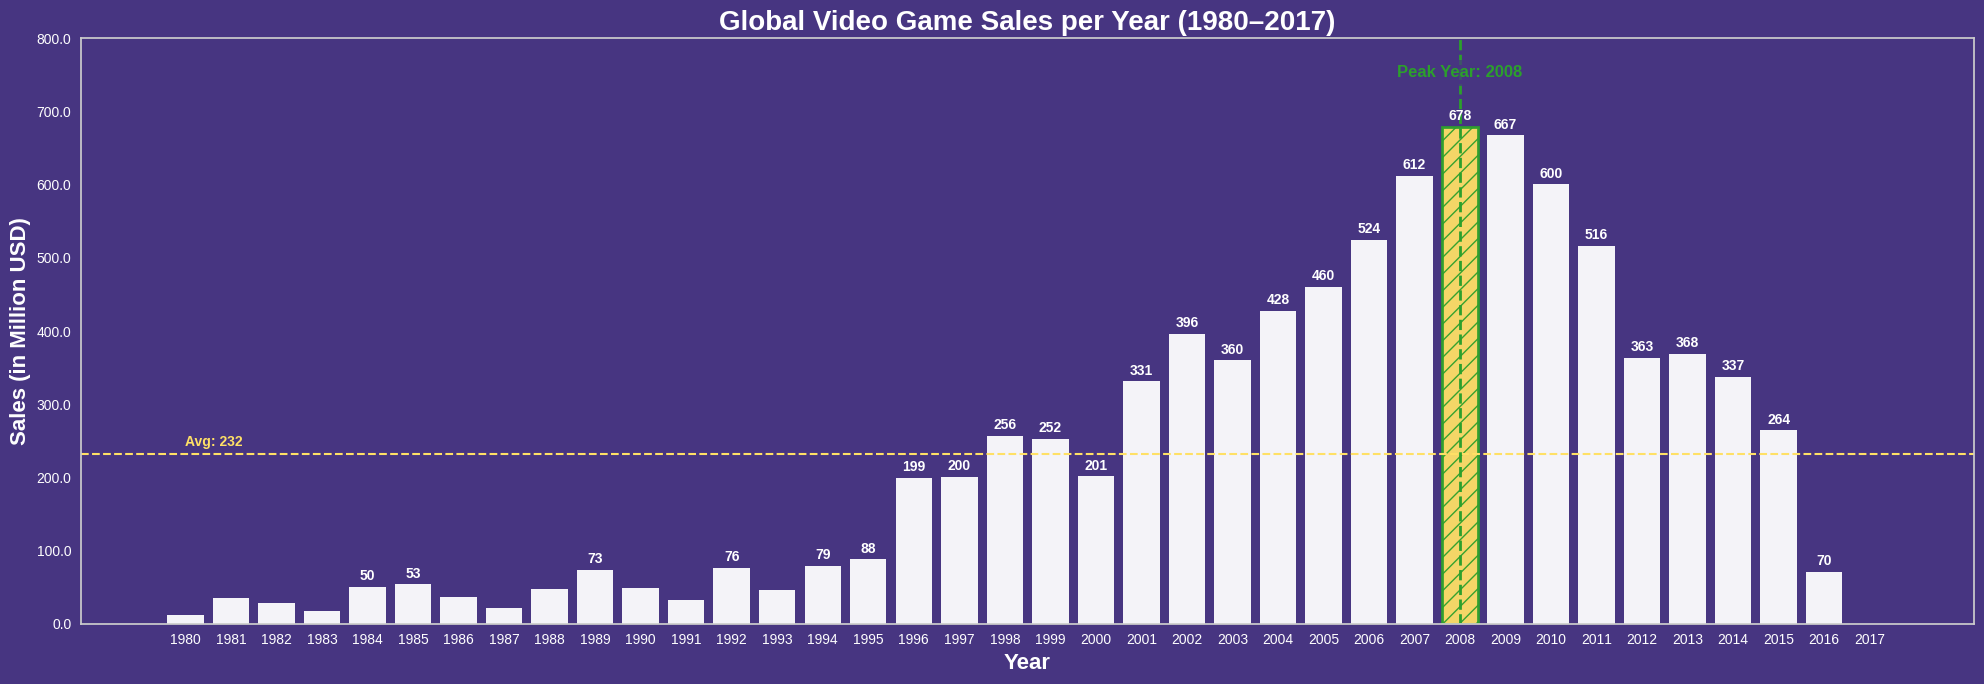

In [30]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

df_year = df.groupby('Year').sum().reset_index(drop=False)

max_value = df_year['Global_Sales'].max()
max_year = df_year[df_year['Global_Sales'] == max_value]['Year'].values[0]

figsize = [20, 7]
x = df_year['Year']
y = df_year['Global_Sales']
width = 0.8

# Pewarnaan kontras
bar_color = '#ffffff'      # Putih untuk bar biasa
peak_color = '#ffe066'     # Kuning untuk isi peak year
hatch_color = '#2ca02c'    # Hijau untuk garis hatch peak year
colors = [peak_color if year == max_year else bar_color for year in x]

# Setup figure & axis
fig, ax = plt.subplots(figsize=figsize)
fig.patch.set_facecolor('#473581')
ax.set_facecolor('#473581')

bars = ax.bar(x, y, width=width, color=colors, alpha=0.95, edgecolor='none')

# Hatch dan edgecolor hijau untuk peak year
for i, bar in enumerate(bars):
    if x.iloc[i] == max_year:
        bar.set_hatch('//')
        bar.set_edgecolor(hatch_color)   # Hatch warna hijau
        bar.set_linewidth(2)             # Agar hatch lebih jelas

# Label di atas bar
for bar in bars:
    yval = bar.get_height()
    if yval > 50:
        ax.text(bar.get_x() + bar.get_width()/2, yval + 5,
                f'{int(yval)}', ha='center', va='bottom', fontsize=10, color='white', fontweight='bold')

# Garis rata-rata & label avg
avg_sales = df_year['Global_Sales'].mean()
ax.axhline(avg_sales, color=peak_color, linestyle='--', linewidth=1.5)
ax.text(x.min(), avg_sales + 10, f'Avg: {int(avg_sales)}', color=peak_color, fontsize=10, fontweight='bold')

# Anotasi peak year
ax.axvline(max_year, color=hatch_color, linestyle='dashed', linewidth=2)
offset = df_year['Global_Sales'].max() * 0.1
ax.text(max_year, max_value + offset,
        f'Peak Year: {max_year}', color=hatch_color,
        ha='center', fontsize=12, fontweight='bold',
        bbox=dict(facecolor='#473581', alpha=0.7, edgecolor='none'))

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

ax.set_title('Global Video Game Sales per Year (1980–2017)',
             fontdict={'fontweight': 'bold', 'fontsize': 20, 'color': 'white'})
ax.set_xlabel('Year', fontsize=16, fontweight='bold', color='white')
ax.set_ylabel('Sales (in Million USD)', fontsize=16, fontweight='bold', color='white')
ax.set_xticks(df_year['Year'])
ax.set_xticklabels(df_year['Year'], color='white', fontsize=10)
ax.set_yticklabels(ax.get_yticks(), color='white', fontsize=10)
ax.set_ylim(0, 800)

ax.grid(False)   # Hilangkan gridlines

plt.tight_layout()
plt.show()


<ipython-input-13-f39a6d3bd459>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_genre['Genre'], rotation=45, color='white', fontsize=11)
<ipython-input-13-f39a6d3bd459>:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), color='white', fontsize=11)


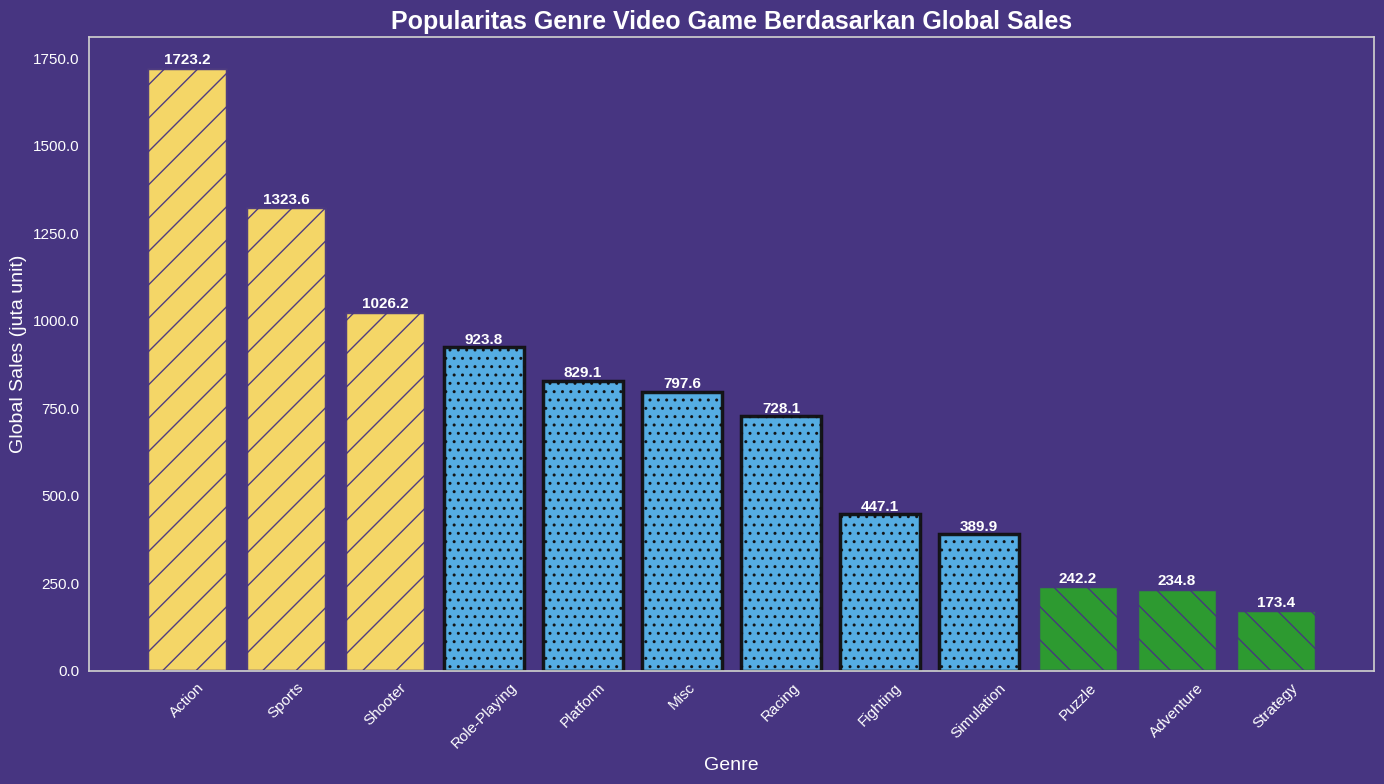

In [ ]:
import matplotlib.pyplot as plt

# Data
df_genre = df.groupby('Genre').sum().reset_index(drop=False)
df_genre = df_genre.sort_values(by='Global_Sales', ascending=False)

figsize = [14, 8]
bar_colors = []
hatches = []
hatch_colors = []

for genre in df_genre['Genre']:
    if genre in ['Action', 'Sports', 'Shooter']:
        bar_colors.append('#ffe066')   # Kuning terang
        hatches.append('/')            # Miring kanan
        hatch_colors.append('#473581') # Hatch ungu tua (kontras kuning)
    elif genre in ['Strategy', 'Puzzle', 'Adventure']:
        bar_colors.append('#2ca02c')   # Hijau terang
        hatches.append('\\')           # Miring kiri
        hatch_colors.append('#473581') # Hatch ungu tua (kontras hijau)
    else:
        bar_colors.append('#56B4E9')   # Biru muda
        hatches.append('..')           # Titik-titik
        hatch_colors.append('#111111') # Hatch hitam (kontras biru muda)

# Plot
fig, ax = plt.subplots(figsize=figsize)
fig.patch.set_facecolor('#473581')
ax.set_facecolor('#473581')

bars = ax.bar(df_genre['Genre'], df_genre['Global_Sales'], color=bar_colors, alpha=0.95, linewidth=2)

# Hatch dan edgecolor kontras
for bar, hatch, edgecol in zip(bars, hatches, hatch_colors):
    bar.set_hatch(hatch)
    bar.set_edgecolor(edgecol)  # Warna hatch (bukan warna bar)
    bar.set_linewidth(2.5)

# Label di atas bar (putih)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}',
            ha='center', va='bottom', fontsize=11, color='white', fontweight='bold')

# Sumbu & judul (putih)
ax.set_title('Popularitas Genre Video Game Berdasarkan Global Sales', fontsize=18, fontweight='bold', color='white')
ax.set_xlabel('Genre', fontsize=14, color='white')
ax.set_ylabel('Global Sales (juta unit)', fontsize=14, color='white')
ax.set_xticklabels(df_genre['Genre'], rotation=45, color='white', fontsize=11)
ax.set_yticklabels(ax.get_yticks(), color='white', fontsize=11)

ax.grid(False)  # Hilangkan gridlines

plt.tight_layout()
plt.show()


In [ ]:
# Grouping sales by platform
platform = df[['Platform', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales']]
platform = platform.groupby('Platform').sum().sort_values('Global_Sales', ascending=False).reset_index(drop=False).head(10)
platform.style.set_properties(**{'background-color': 'turquoise'}, subset=['Global_Sales'])    # Highlight c column

,Platform,NA_Sales,EU_Sales,JP_Sales,Global_Sales
0,PS2,580.300000,337.000000,137.630000,1247.160000
1,X360,594.870000,278.070000,12.310000,970.270000
2,PS3,388.900000,340.470000,79.210000,949.350000
3,Wii,497.800000,264.350000,68.280000,910.280000
4,DS,388.300000,194.070000,175.020000,818.690000
5,PS,335.520000,212.930000,139.780000,728.850000
6,GBA,184.120000,74.590000,46.560000,313.560000
7,PSP,108.010000,67.190000,75.890000,292.700000
8,PS4,96.800000,123.700000,14.300000,278.100000
9,PC,92.160000,137.890000,0.170000,255.410000


In [ ]:
# Grouping sales by genre
publishers = df[['Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales']]
publishers = publishers.groupby('Publisher').sum().sort_values('Global_Sales', ascending=False).reset_index(drop=False).head(10)
publishers.style.set_properties(**{'background-color': 'lightgreen'}, subset=['Global_Sales'])    # Highlight a column

,Publisher,NA_Sales,EU_Sales,JP_Sales,Global_Sales
0,Nintendo,815.750000,418.300000,454.990000,1784.430000
1,Electronic Arts,590.580000,370.100000,14.040000,1103.830000
2,Activision,426.010000,213.720000,6.540000,721.410000
3,Sony Computer Entertainment,265.220000,187.550000,74.100000,607.280000
4,Ubisoft,252.540000,163.030000,7.330000,473.250000
5,Take-Two Interactive,220.470000,117.950000,5.830000,399.300000
6,THQ,208.600000,94.600000,5.010000,340.440000
7,Konami Digital Entertainment,88.910000,68.620000,90.930000,278.560000
8,Sega,108.780000,81.420000,56.190000,270.720000
9,Namco Bandai Games,69.380000,42.610000,126.840000,253.650000


<ipython-input-27-2f796c9e179a>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), color='white', fontsize=12)


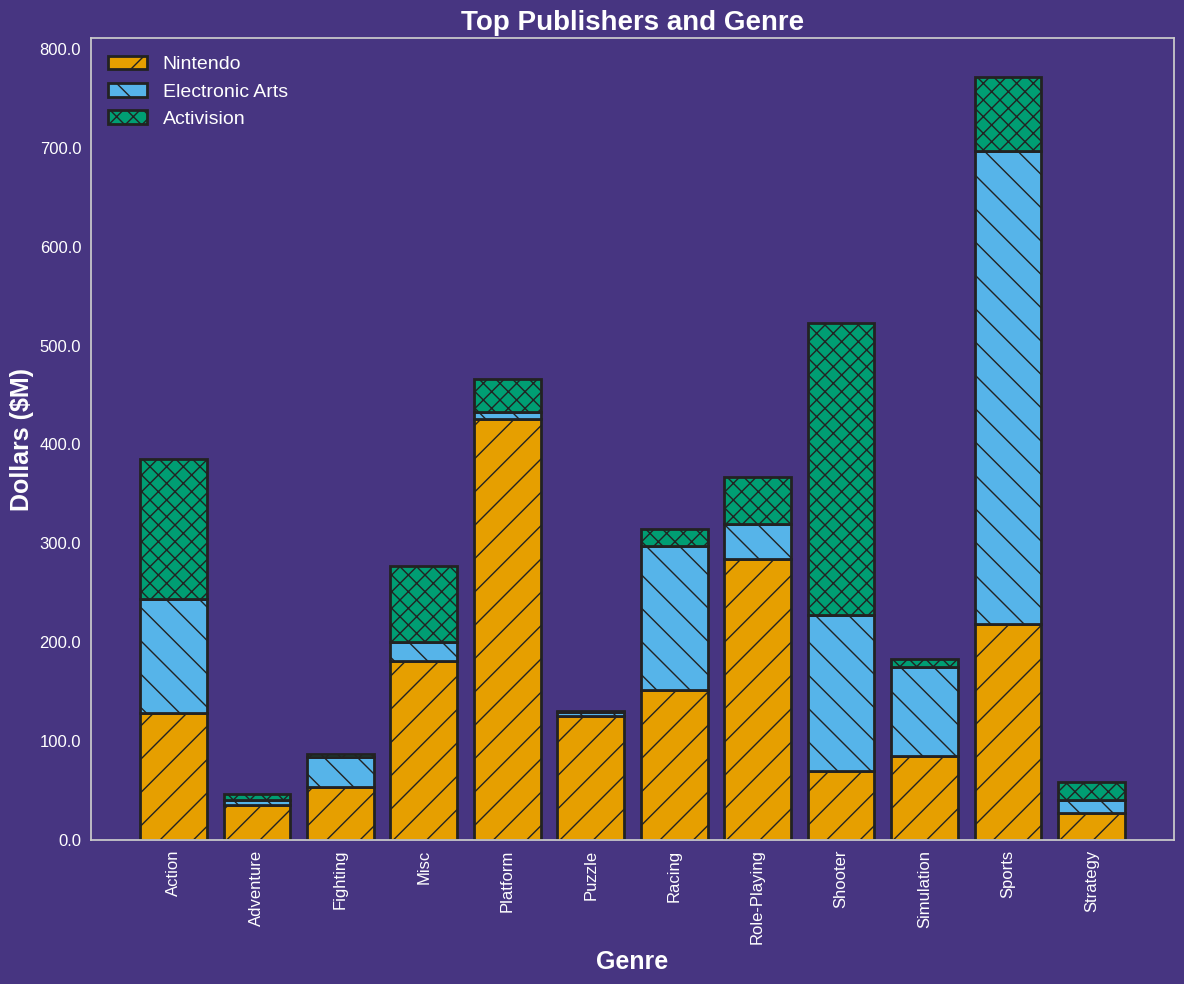

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data sudah diolah di atas
labels = [i for i in nd['Genre']]
y1 = np.array([i for i in nd['Global_Sales']])
y2 = np.array([j for j in ea['Global_Sales']])
y3 = np.array([k for k in av['Global_Sales']])

fig, ax = plt.subplots(figsize=(12, 10))
fig.patch.set_facecolor('#473581')
ax.set_facecolor('#473581')

bars1 = ax.bar(labels, y1, color='#E69F00', hatch='/', label='Nintendo', edgecolor='#222', linewidth=2)
bars2 = ax.bar(labels, y2, bottom=y1, color='#56B4E9', hatch='\\', label='Electronic Arts', edgecolor='#222', linewidth=2)
bars3 = ax.bar(labels, y3, bottom=y1+y2, color='#009E73', hatch='xx', label='Activision', edgecolor='#222', linewidth=2)

# Sumbu dan judul putih
ax.set_title('Top Publishers and Genre', fontdict={'fontweight':'bold', 'fontsize':20, 'color':'white'})
ax.set_xlabel('Genre', fontdict={'fontsize':18, 'fontweight':'bold', 'color':'white'})
ax.set_ylabel('Dollars ($M)', fontdict={'fontsize':18, 'fontweight':'bold', 'color':'white'})
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, color='white', fontsize=12)
ax.set_yticklabels(ax.get_yticks(), color='white', fontsize=12)

# Legend putih, background ungu
leg = ax.legend(fontsize=14, facecolor='#473581')
plt.setp(leg.get_texts(), color='white')
leg.get_frame().set_edgecolor('#473581')

# Hilangkan gridlines
ax.grid(False)

plt.tight_layout()
plt.show()


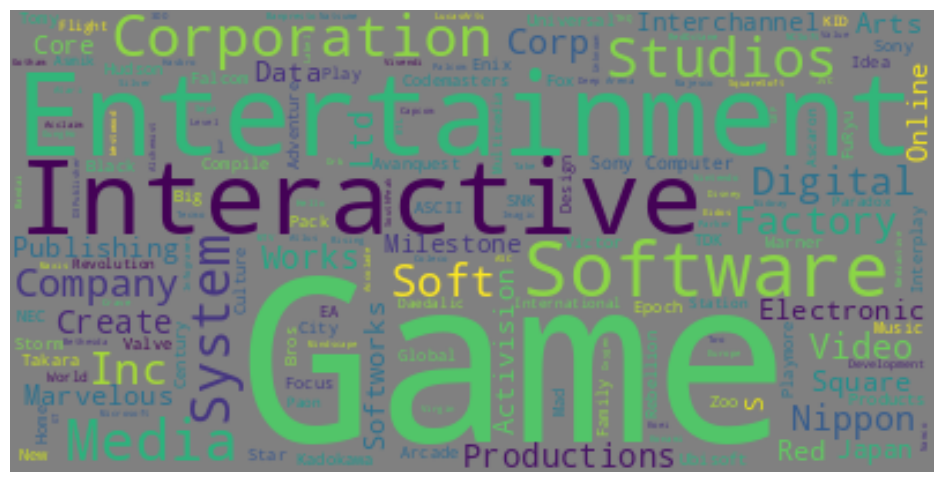

In [ ]:
# Creating word cloud
text = ' '.join(df['Publisher'].unique())
wordcloud = WordCloud(max_font_size=100, background_color='gray').generate(text)

plt.figure(figsize=(17, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

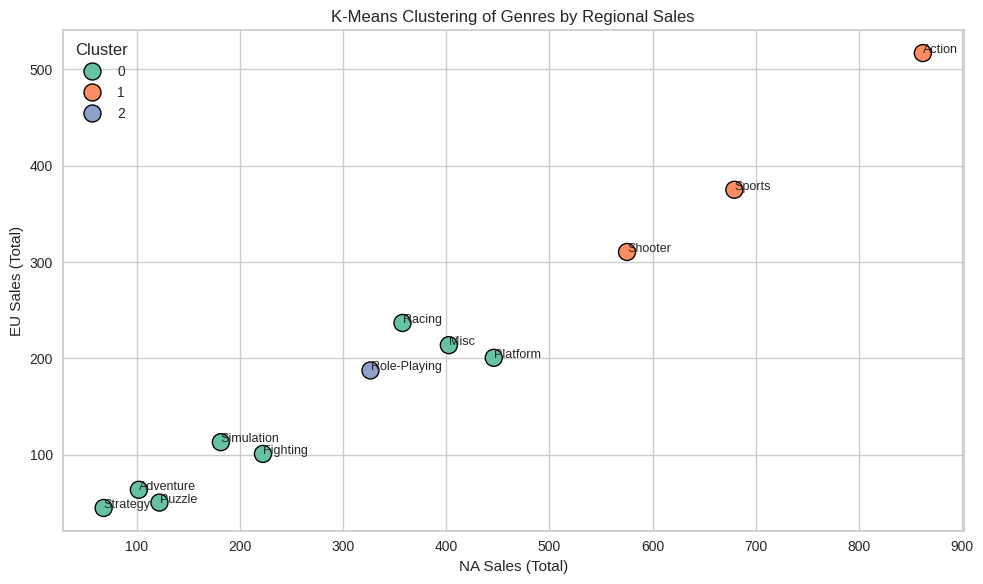

In [ ]:
# 📊 Aggregate total sales per region per Genre
region_sales = df.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()

# 🔄 Standardize the features
scaler = StandardScaler()
scaled_region_sales = scaler.fit_transform(region_sales)

# 🔗 Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
region_sales['Cluster'] = kmeans.fit_predict(scaled_region_sales)

# 🔍 Reset index agar bisa divisualisasikan
region_sales_reset = region_sales.reset_index()

# 📈 Scatterplot visualisasi (NA vs EU sebagai representasi)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=region_sales_reset,
    x='NA_Sales',
    y='EU_Sales',
    hue='Cluster',
    palette='Set2',
    s=150,
    edgecolor='black'
)

# ✍️ Tambahkan label genre ke setiap titik
for _, row in region_sales_reset.iterrows():
    plt.text(row['NA_Sales'] + 0.05, row['EU_Sales'], row['Genre'], fontsize=9)

# 🖼️ Format plot
plt.title('K-Means Clustering of Genres by Regional Sales')
plt.xlabel('NA Sales (Total)')
plt.ylabel('EU Sales (Total)')
plt.grid(True)
plt.tight_layout()
plt.show()

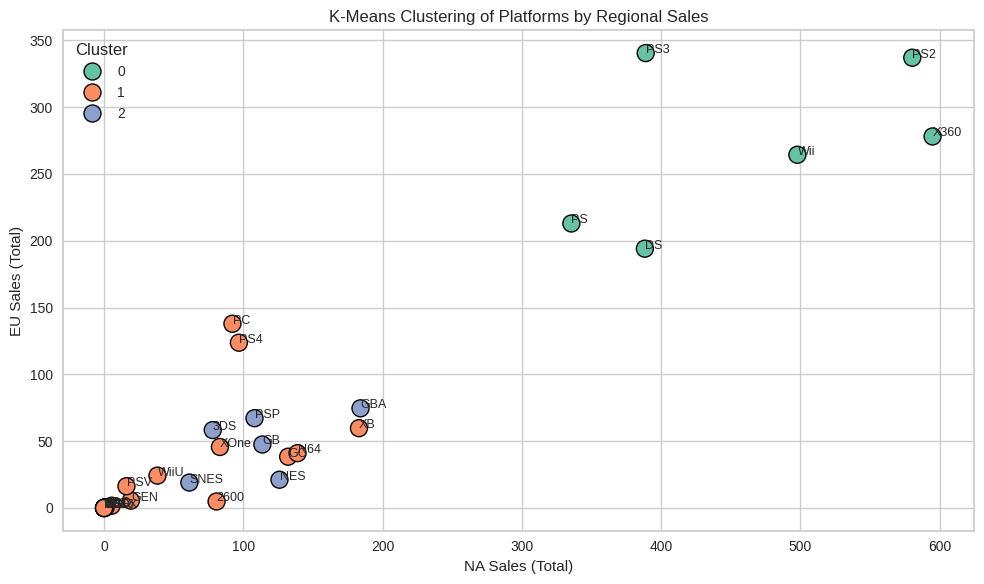

In [ ]:
# 📊 Aggregate sales per platform per region
platform_sales = df.groupby('Platform')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()

# 🔄 Standardize data
scaler = StandardScaler()
scaled_platform_sales = scaler.fit_transform(platform_sales)

# 🔗 K-Means clustering
kmeans_platform = KMeans(n_clusters=3, random_state=42, n_init=10)
platform_sales['Cluster'] = kmeans_platform.fit_predict(scaled_platform_sales)

# 🔄 Reset index untuk plotting
platform_sales_reset = platform_sales.reset_index()

# 📈 Plot: visualisasi cluster (NA vs EU sebagai sumbu)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=platform_sales_reset,
    x='NA_Sales',
    y='EU_Sales',
    hue='Cluster',
    palette='Set2',
    s=150,
    edgecolor='black'
)

# ✍️ Label nama platform
for _, row in platform_sales_reset.iterrows():
    plt.text(row['NA_Sales'] + 0.05, row['EU_Sales'], row['Platform'], fontsize=9)

plt.title('K-Means Clustering of Platforms by Regional Sales')
plt.xlabel('NA Sales (Total)')
plt.ylabel('EU Sales (Total)')
plt.grid(True)
plt.tight_layout()
plt.show()

Counts per Dominant Region:
Dominant_Region
NA       9941
JP       3987
EU       2344
Other      76
Name: count, dtype: int64


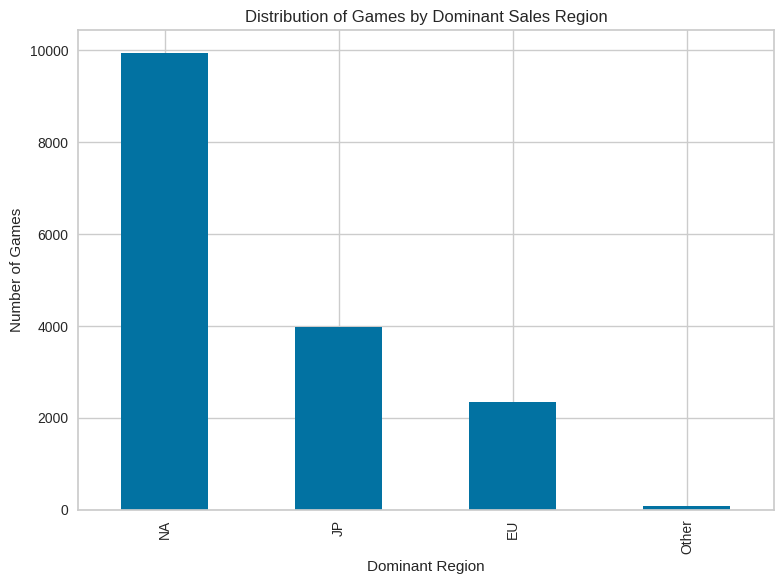

In [ ]:
regions = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
df['Dominant_Region'] = df[regions].idxmax(axis=1).str.replace('_Sales', '')

# 3. Hitung jumlah game per segmen
counts = df['Dominant_Region'].value_counts()

# 4. Tampilkan ringkasan counts
print("Counts per Dominant Region:")
print(counts)

# 5. Visualisasi: bar chart distribusi segmentasi
plt.figure(figsize=(8, 6))
counts.plot(kind='bar')
plt.xlabel('Dominant Region')
plt.ylabel('Number of Games')
plt.title('Distribution of Games by Dominant Sales Region')
plt.tight_layout()
plt.show()

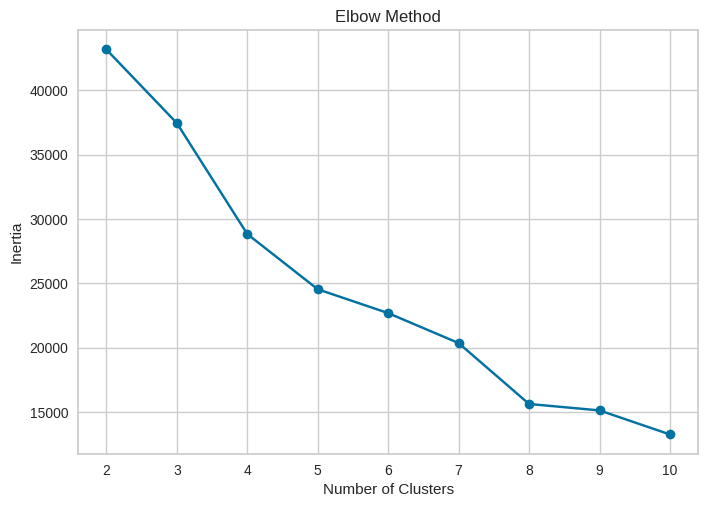

In [ ]:
sales_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
df_sales = df[sales_cols].dropna()
scaler = StandardScaler()
scaled_sales = scaler.fit_transform(df_sales)
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42,)
    kmeans.fit(scaled_sales)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

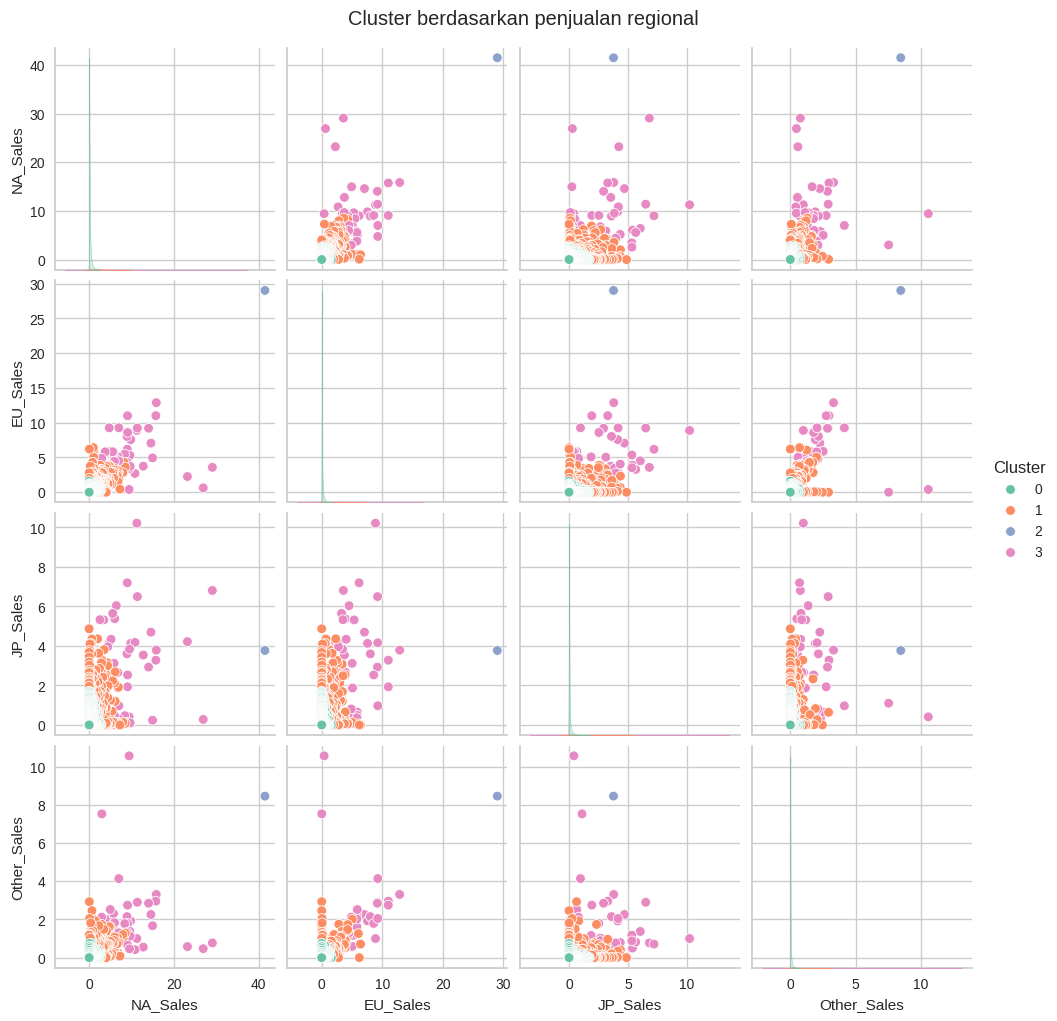

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_sales)
sns.pairplot(df, vars=sales_cols, hue='Cluster', palette='Set2')
plt.suptitle("Cluster berdasarkan penjualan regional", y=1.02)
plt.show()

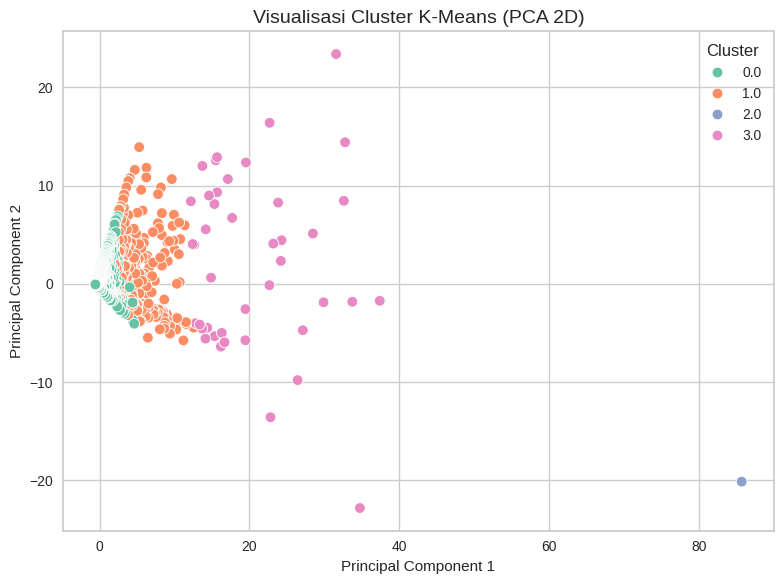

In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_sales)

df_pca = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df['Cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=60)
plt.title("Visualisasi Cluster K-Means (PCA 2D)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
centroids = kmeans.cluster_centers_

from sklearn.metrics import pairwise_distances_argmin_min

# Assign cluster ke data
labels = kmeans.labels_

# Hitung jarak tiap titik ke centroid-nya
closest, distances = pairwise_distances_argmin_min(scaled_sales, kmeans.cluster_centers_)

# Tambahkan ke dataframe (misal df sudah ada)
df['Cluster'] = labels
df['Distance_to_Centroid'] = distances



In [ ]:
cluster_2 = df[df['Cluster'] == 2]
outliers = cluster_2.sort_values(by='Distance_to_Centroid', ascending=False).head()
cluster_2

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Dominant_Region,Cluster,Distance_to_Centroid
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,NA,2,0.00


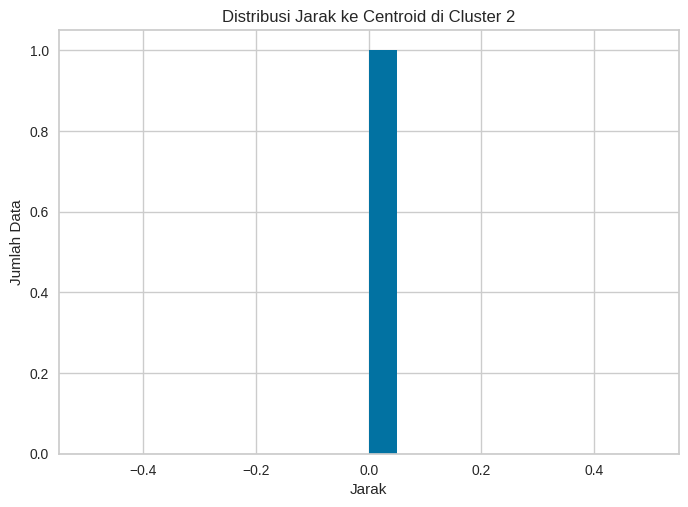

In [ ]:

plt.hist(cluster_2['Distance_to_Centroid'], bins=20)
plt.title("Distribusi Jarak ke Centroid di Cluster 2")
plt.xlabel("Jarak")
plt.ylabel("Jumlah Data")
plt.show()